In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import numpy as np
import os
import re
import sys
from ijson import items
import json
import pprint
import configparser
from skimage.io import imread 
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

sys.path.append(os.path.abspath('../Module'))
import preprocessing
import visualize

config = configparser.ConfigParser()
config.read('../config.ini')

vg_json = config['PATHS']['vg-json']
vg_json_export = config['PATHS']['json-export']
image_dir = config['PATHS']['vg-images']

In [4]:
colors = preprocessing.basic_colors()

In [5]:
def plot_object(row, img_dir):
    
    try:
        image_id = row.image_id
        color = row.color
        color_pred = row.color_pred
        object_id = row.object_id
        name = row.object_name
        h = row.bb_h
        w = row.bb_w
        x = row.bb_x
        y = row.bb_y
    except:
        print ('entry missing')
        return
    
    filename = img_dir+str(image_id)+'.jpg'
    
    img = imread(filename)
    title = '{obj}, color (annotated):{clr}, color (predicted):{clr_pred}'.format(obj=name,clr=color,clr_pred=color_pred)
    
    # Bild plotten
    fig,ax = plt.subplots(figsize=(10,10))
    ax.imshow(img)
    ax.set_title(title)
    
    # BB hinzufügen
    rect = patches.Rectangle((x,y),w,h,linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
    
    plt.show()
    
    pass

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Quelle: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots(figsize=(10,10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


## DF mit Test-Split importieren

In [6]:
all_obj = pd.read_csv(vg_json_export+"extracted_data/test_df.csv", index_col=0)#.reset_index(drop=False)

# Frequente Objekte + CDOs + CNOs:
frequent_objects, color_diagnostic_objects, color_neutral_objects = preprocessing.freq_cdo_cno(all_obj, num_cdos=100, num_cnos=100, min_num=100)

# all_obj auf frequente Objekte reduzieren
freq_obj = all_obj.loc[all_obj.object_name.isin(frequent_objects)]

# DataFrames für CDOs und CNOs

cd_obj = freq_obj .loc[freq_obj.object_name.isin(color_diagnostic_objects.keys())]
cn_obj = freq_obj.loc[freq_obj.object_name.isin(color_neutral_objects)]

## Label- und Prediction-Arrays importieren

In [7]:
os.listdir(vg_json_export)

['w2c_data.npz',
 '.ipynb_checkpoints',
 'vandeweijer2007',
 'extracted_data',
 'pixelwise_rgb_color.npz']

In [8]:
import_arrays = np.load(vg_json_export+'pixelwise_rgb_color.npz')
import_arrays.files

['test_chip_w2c', 'test_w2c']

In [161]:
predict_y = import_arrays['test_w2c']
ids = predict_y[:,0:1]

## Predictions und Test-DF zusammenführen
Resultat: Ein DF pro Bedingung (alle Objekte, CDO, CDO mit Memory Color, CDO ohne Memory Color)

In [162]:
# DataFrame aus Predictions (np-Array) erstellen
predict_df =  pd.DataFrame(data=predict_y[0:,1:],index=predict_y[0:,0],columns=[colors])
# Farbwort mit höchstem Wert (-> prognostiziertes Farbwort) (ergibt pd.Series)
pred_c = predict_df.idxmax(axis=1)
# pred-Series als Column von all_objects
predict_df.columns = [c[0] if type(c) == tuple else c for c in predict_df.columns]
# Tupel in Column-Namen auflösen
predict_df['color_pred'] = predict_df.idxmax(axis=1)
# all_objects mit all_obj (enthält ids, bbs, Objektnamen, Farbattribute) zusammenführen
predict_df = all_obj.join(predict_df, how='inner')

# Types anpassen
predict_df['color']=predict_df['color'].astype(str)
predict_df['color_pred']=predict_df['color_pred'].astype(str)

In [187]:
predict_cdo = predict_df.loc[cd_obj.index.to_list()]
predict_cno = predict_df.loc[cn_obj.index.to_list()]

## Ergebnisse überprüfen

### Scores

In [188]:
score_all = len(predict_df.loc[predict_df['color'] == predict_df['color_pred']]) / len(predict_df)
score_cdo = len(predict_cdo.loc[predict_cdo['color'] == predict_cdo['color_pred']]) / len(predict_cdo)
score_cno = len(predict_cno.loc[predict_cno['color'] == predict_cno['color_pred']]) / len(predict_cno)

print('All Objects: {a}, Color-Diagnostic Objects: {b}, Color-Neutral Objects: {c}'.format(a=score_all, b=score_cdo, c=score_cno))

All Objects: 0.37956270798668884, Color-Diagnostic Objects: 0.4277143916752111, Color-Neutral Objects: 0.40621342477567196


### Alle Objekte

In [189]:
predict_df.loc[predict_df['color'] != predict_df['color_pred']].sort_values('object_name')\
    .sample(n=5)

bb_h  bb_w  bb_x  bb_y   color  image_id  object_id object_name  \
457991.0    58   498     1     2   white   2364391     641360         sky   
259533.0    18    28   260   302  yellow   2389112    4502777        sign   
523063.0   272   250   109    66   white   2357216    1676677       truck   
162434.0    13     7   142   251    blue   2402077     392946     diamond   
813453.0   270   496     3    99   white   2321448    4199560       plate   

             black      blue     brown      gray     green    orange  \
457991.0  0.089538  0.405083  0.060754  0.065924  0.085017  0.044545   
259533.0  0.103890  0.058760  0.187853  0.075660  0.078488  0.210748   
523063.0  0.142995  0.164427  0.086035  0.172513  0.099112  0.035676   
162434.0  0.083029  0.032817  0.196824  0.250567  0.076434  0.039446   
813453.0  0.040412  0.013805  0.132115  0.021485  0.125250  0.176598   

              pink    purple       red     white    yellow color_pred  
457991.0  0.021386  0.063598  0.040990  0.049469  0.073696       blue  
259533.0  0.029096  0.086363  0.068990  0.007277  0.092876     orange  
523063.0  0.049018  0.060563  0.042037  0.061240  0.086384       gray  
162434.0  0.091646  0.074593  0.059959  0.028172  0.066513       gray  
813453.0  0.029774  0.056994  0.098224  0.006188  0.299154     yellow

/home/simeon/Dokumente/Uni/Masterarbeit/Daten/VirtualEnvs/ma_env/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide


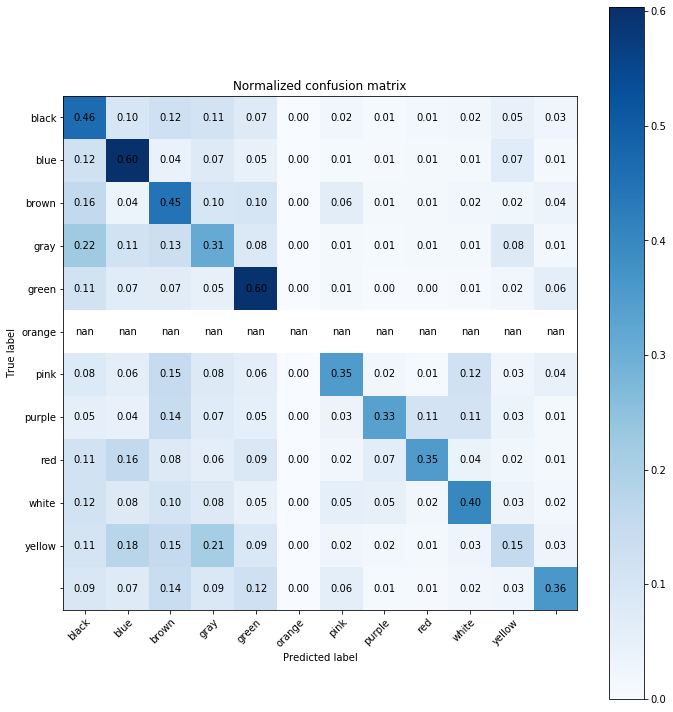

In [194]:
plot_confusion_matrix(predict_df.color, predict_df.color_pred, classes=colors, normalize=True)

(12, 12)

In [168]:
len(predict_df.loc[predict_df['color'] == predict_df['color_pred']].sort_values('object_name')\
    .loc[predict_df['color'] == 'black']
   )

12529

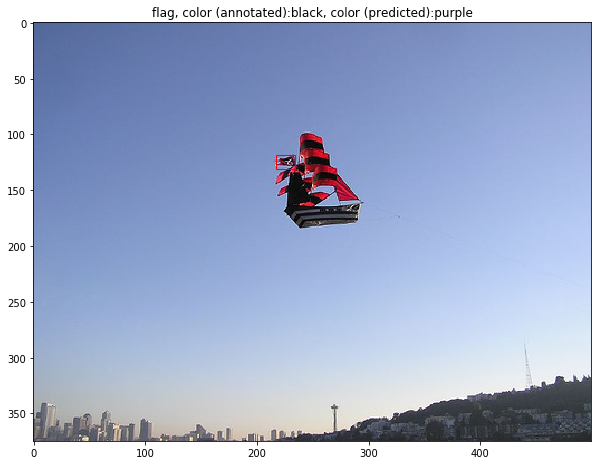

519968.0    None
dtype: object

In [173]:
predict_df.loc[predict_df['color'] != predict_df['color_pred']].sort_values('object_name')\
    .sample(n=1)\
    .apply(lambda x:plot_object(x, image_dir), axis=1)

### Color Diagnostic Objects

In [170]:
predict_cdo.loc[predict_cdo['color'] != predict_cdo['color_pred']].sort_values('object_name')\
    .sample(n=5)

bb_h  bb_w  bb_x  bb_y  color  image_id  object_id object_name  \
730917    92   132   181   122  white   2333128    3175808      remote   
76580    122    89    28    79  white   2412537    4021723         cow   
593804    15     9   228   409  white   2349323    3599869        spot   
478470   288   495     3    82   blue   2362045    2447106       plate   
99565    170   480    17     2   gray   2409405     242433         sky   

           black      blue     brown      gray     green    orange      pink  \
730917  0.076128  0.126721  0.105249  0.189760  0.068338  0.039290  0.070131   
76580   0.187715  0.028880  0.185702  0.082457  0.095100  0.076545  0.051606   
593804  0.295320  0.082207  0.070571  0.269317  0.067720  0.020353  0.039885   
478470  0.111908  0.039510  0.152555  0.061475  0.110413  0.146681  0.069117   
99565   0.106026  0.072796  0.057910  0.127438  0.049953  0.041473  0.084217   

          purple       red     white    yellow color_pred  
730917  0.066712  0.075168  0.126060  0.056441       gray  
76580   0.076067  0.059305  0.010757  0.145867      black  
593804  0.063655  0.030620  0.017821  0.042532      black  
478470  0.066537  0.080092  0.023610  0.138102      brown  
99565   0.062149  0.052952  0.301281  0.043806      white

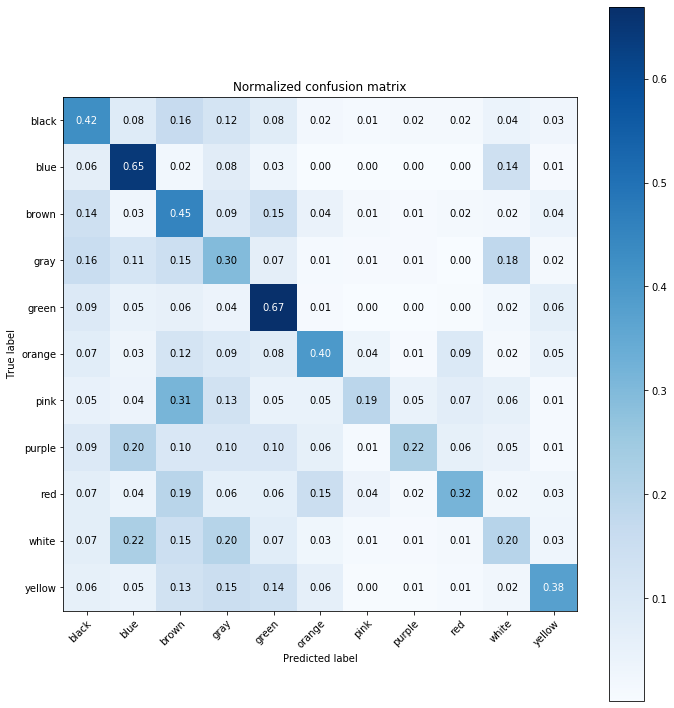

In [171]:
plot_confusion_matrix(predict_cdo.color, predict_cdo.color_pred, classes=colors, normalize=True)

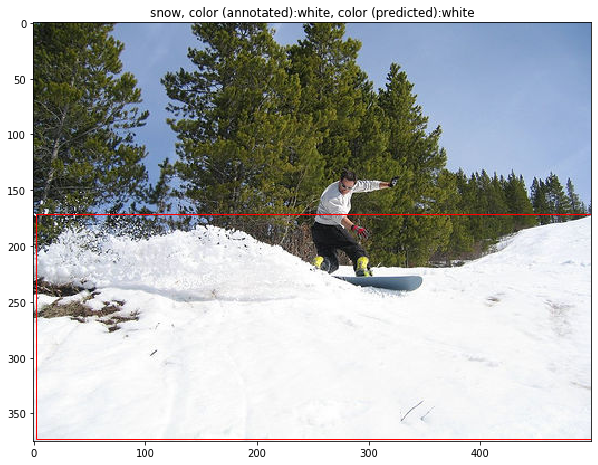

314977    None
dtype: object

In [172]:
predict_cdo.loc[predict_cdo['color'] == predict_cdo['color_pred']].sort_values('object_name')\
    .sample(n=1)\
    .apply(lambda x:plot_object(x, image_dir), axis=1)